# 基于Attention U-net快速识别山体滑坡区域

## 安装两个需要使用的到包
- segmentation-models：这是一个用于图像分割任务的深度学习模型库，这里我们主要使用这个包中的几个评估指标(metrics).
- rasterio:主要是用于对读取和写入栅格数据的包。

In [1]:
# !pip install segmentation-models rasterio

## 导入本次论文复现需要使用到的包

In [2]:
# 基础模块导入
import numpy as np
import pandas as pd
import h5py
import time
import os
import random
import rasterio
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# TensorFlow和Keras相关模块导入
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose,
                                     BatchNormalization, Dropout, Activation, add, multiply, Lambda, 
                                     AveragePooling2D, average)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.initializers import glorot_normal, random_normal, random_uniform
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.applications import VGG19, densenet

# 第三方模块导入
import cv2
import segmentation_models as sm
from rasterio.plot import show

# 确保segmentation_models使用的是TensorFlow版本的Keras,一般不会出现
keras = tf.keras

Segmentation Models: using `keras` framework.


## 其他预设置和导入数据

In [3]:
# 设置图像数据格式
K.set_image_data_format('channels_last')
#set_image_data_format('channels_last')是一个函数调用，它指定了图像数据的维度顺序。
#在这种情况下，'channels_last'意味着图像数据的张量形式应该是(samples, height, width, channels)。即，通道维（如RGB颜色通道）位于张量的最后一个维度。这是TensorFlow的默认设置

# 设置权重初始化方法
kinit = 'glorot_normal'
#glorot_normal'是Glorot正态分布初始化器。


### 明确损失函数和评价指标

当训练神经网络时，损失函数和评估指标扮演了不同的角色，它们对于模型的训练和评估至关重要。下面详细解释一下损失函数和评估指标的含义和作用：

### 1. 损失函数（Loss Function）
- **定义：** 损失函数是用来衡量模型预测值与真实标签之间的差异的函数。它是优化算法的目标函数，通过最小化损失函数，模型可以学习将输入映射到正确的输出。
- **作用：**
  - **指导训练：** 损失函数在模型训练过程中起着至关重要的作用，它通过计算模型输出与真实标签之间的误差来调整模型参数，使模型能够逐渐减小损失值，提高预测的准确性。
  - **反向传播：** 通过梯度下降等优化算法计算损失函数的梯度，并沿着梯度的反方向更新模型的权重，以最小化损失函数。

### 2. 评估指标（Metrics）
- **定义：** 评估指标是用来评估模型性能和表现的指标，通常用于监测模型在训练和测试集上的表现。
- **作用：**
  - **性能评估：** 评估指标提供了一种度量模型性能的方式，比如精确率、召回率、F1分数等，可以帮助我们了解模型在各个方面的表现。
  - **比较模型：** 通过评估指标，可以比较不同模型在相同任务上的表现，从而选择最适合问题的模型。
  - **调试和优化：** 评估指标可以帮助我们发现模型存在的问题，并且帮助我们优化模型的性能。

### 区别与联系
- **区别：** 损失函数主要用于训练过程中指导模型参数的更新，评估指标用于评估模型的整体性能。
- **联系：** 二者都是用来衡量模型的性能，但在不同的阶段发挥作用，共同协助训练出高性能的机器学习模型。

综合来说，损失函数和评估指标在神经网络训练中起着不可替代的作用，它们共同帮助我们监控、调整和评估模型的性能，从而达到更好的训练效果和更可靠的模型表现。

#### 1. 损失函数（Loss Function）


<img src="../data/image/loss_function.png" width="1000" height="1500">

这段代码定义了两个函数，`dsc` 和 `dice_loss`，用于计算 Dice 系数和 Dice 损失。以下是它们的作用和原理：

1. **Dice 系数 (Dice coefficient)：**
   - `dsc` 函数用于计算预测结果与真实标签之间的 Dice 系数。Dice 系数是一种用来评估两个集合相似度的指标，常用于图像分割任务中。
   - 具体计算过程为：首先将真实标签和预测结果展平成一维向量，然后计算它们的交集，最后根据 Dice 系数的公式计算得分。
   - 公式：Dice = (2 * |Y_true ∩ Y_pred| + smooth) / (|Y_true| + |Y_pred| + smooth)，其中 |Y_true| 表示真实标签的元素数目，|Y_pred| 表示预测结果的元素数目。

2. **Dice 损失 (Dice loss)：**
   - `dice_loss` 函数通过取 1 减去 Dice 系数的方式，定义了 Dice 损失。这意味着 Dice 损失越小，Dice 系数越大，表示模型预测结果与真实标签越相似。
   - 一般来说，优化目标是最小化 Dice 损失，以提高模型在图像分割任务中的性能。

总的来说，这段代码实现了计算 Dice 系数和定义 Dice 损失的功能，用于评估模型在图像分割任务中的准确性和优化模型参数。Dice 系数和 Dice 损失是常用的评价指标和损失函数，在医学图像处理等领域得到广泛应用。

计算交集时，我们需要将真实标签（y_true）和预测标签（y_pred）展平（flatten）成一维向量，这样可以方便进行相应元素的逐个相乘操作，得到各个位置上的交集值。在深度学习中，通常使用这种计算方法来计算交集，以便进一步计算 IoU（Intersection over Union）等指标。

细化一下这个过程：

1. `y_true_f = K.flatten(y_true)` 和 `y_pred_f = K.flatten(y_pred)`：将真实标签和预测标签展平成一维向量，方便进行逐元素操作。

2. `intersection = K.sum(y_true_f * y_pred_f)`：计算交集，这里通过将展平后的真实标签和预测标签进行逐元素相乘，然后将相乘后的结果相加，即得到了交集的值。相乘的效果类似于在二值化的标签中，1 表示有目标，0 表示背景，两者相乘后会得到交集。

In [4]:
import tensorflow.keras.backend as K


def dsc(y_true, y_pred):
    smooth = 1
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth ) / (K.sum(y_true_f)+ K.sum(y_pred_f)+smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 -dsc(y_true, y_pred)
    return loss




#### 2.评估指标（Metrics）

这段代码是用于定义评估指标(metrics)的列表。在这里，使用了一些来自 `segmentation_models` 库的评估指标，具体包括 Precision（精确率）、Recall（召回率）、F-Score 和 IOU Score。

让我们逐个解释每个评估指标的作用和参数含义：

1. **Precision（精确率）**：
   - `sm.metrics.Precision(threshold=0.5)` 表示计算预测结果的精确率。
   - `threshold` 是阈值，用于将模型输出的概率值转换为二值化的预测结果。在这里，当模型输出的概率值大于 0.5 时被视为正类，小于等于 0.5 则被视为负类。

2. **Recall（召回率）**：
   - `sm.metrics.Recall(threshold=0.5)` 表示计算预测结果的召回率。
   - 同样地，`threshold` 是用于二值化预测结果的阈值。

3. **F-Score**：
   - `sm.metrics.FScore(threshold=0.5, beta=1)` 表示计算 F-Score，即综合考虑精确率和召回率的评价指标。
   - `threshold` 仍然是用于二值化预测结果的阈值。
   - `beta` 是 F-Score 中的一个参数，用于调整对精确率和召回率的重视程度。当 `beta=1` 时，表示精确率和召回率同等重要。

4. **IOU Score**（Intersection over Union，即交并比）：
   - `sm.metrics.IOUScore(threshold=0.5)` 表示计算预测结果的交并比。
   - `threshold` 仍然是用于二值化预测结果的阈值。
   - IOU 的计算原理很简单，通过比较预测框（或分割结果）与真实框的重叠程度来评估算法的性能。IOU 的取值范围在 0 到 1 之间，值越接近 1 表示算法预测的结果与真实情况越吻合，值越接近 0 则表示预测的结果与真实情况差异较大。


这些评估指标用于衡量模型在图像分割任务中的性能表现，可以帮助评估模型的准确性、全面性和泛化能力。在训练过程中，这些评估指标将被用来监控模型的性能，并且可以作为训练过程中的损失函数的补充，帮助优化模型参数以达到更好的分割效果。

<img src="../data/image/Accuracy Assessment.png" width="1000" height="600">

In [5]:
metrics = [sm.metrics.Precision(threshold=0.5),
           sm.metrics.Recall(threshold=0.5),
           sm.metrics.FScore(threshold=0.5,beta=1),
           sm.metrics.IOUScore(threshold=0.5)]

### 加载我们的数据

In [6]:
#加载数据
X_train  = np.load(f'../data/SAR_dataset/trainX.npy')
Y_train = np.load(f'../data/SAR_dataset/trainY.npy')
X_test = np.load(f'../data/SAR_dataset/testX.npy')
Y_test = np.load(f'../data/SAR_dataset/testY.npy')

In [7]:
#查看一下数据的长度
X_train.shape,Y_train.shape, X_test.shape, Y_test.shape

((752, 64, 64, 4), (752, 64, 64, 1), (189, 64, 64, 4), (189, 64, 64, 1))

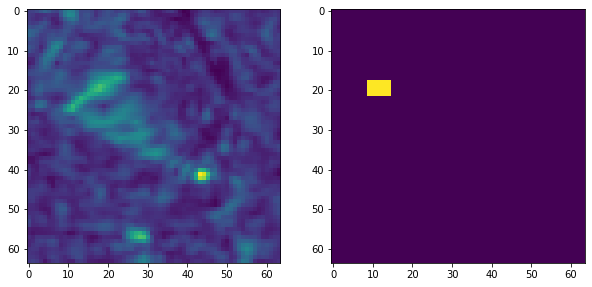

In [8]:
#可视化一下我们的数据
i = 10

f,axarr = plt.subplots(1,2,figsize=(10,10))
axarr[0].imshow(X_test[i][:,:,2])
axarr[1].imshow(np.squeeze(Y_test[i]))


## 构建Attention U-net

<img src="../data/image/attention_u-net.png" width="1000" height="700">

在Attention U-Net中，关键的是将注意力门控（attention gates）集成到网络中，提高网络对图像中关键特征的敏感性。这通常涉及以下两个核心组件：

1. **注意力门控信号 (Attention Gating Signal)**：这是控制注意力的部分。它负责生成门控信号，这些信号会用于后续的注意力门控模块，以指导模型关注到图像的关键区域。

2. **注意力门控块 (Attention Gating Block)**：这个模块接收门控信号，并应用于编码器（或其它网络部分）提供的特征图。这个块会基于门控信号来加权特征图的每个元素，强化或减弱它们，这样网络在融合特征或在后续层进行处理时会更专注于关键区域。

在标准的U-Net中集成注意力门控机制，一般涉及以下步骤：

- **在编码器与解码器间的跳跃连接中加入注意力门控块**：在每个跳跃连接中，将编码器的特征图送入注意力门控块，然后将产生的加权特征图与解码器路径上的特征图融合。

- **设计门控机制**：定义一个网络结构来计算注意力系数。这通常涉及到特定的卷积操作，激活函数，以及后续的乘法操作来对特征图进行加权。

注意力机制的好处是它让模型能够自动学习到在图像分割过程中哪些区域比其他部分更为重要。通过这种方式，Attention U-Net比传统的U-Net在许多情况下能够获得更好的性能，尤其是在图像中有很多干扰信号的情况下。注意力机制助力于减少模型对不重要区域的关注，增强对那些对预测任务至关重要的区域的关注。


注意力门控信号 (Attention Gating Signal):
这一部分是整个注意力机制的关键。我们将会写一个`UnetGatingSignal` 函数负责生成用于控制注意力的门控信号。这些门控信号将作用于来自编码器的特征图，并指导在解码器过程中如何融合特征。

注意力门控块 (Attention Gating Block):
我们将会定义一个`AttnGatingBlock` 来实现注意力调制过程，它接收来自与之相对应编码器层的特征图（这些特征图已经经过相应的预处理以调整通道数），并结合门控信号来决定应该放大还是抑制特定的特征。

如果你在实现一个注意力机制，首先需要将一个全局特征（比如某种注意力得分）应用到每个通道上，则可以通一个函数来扩展这个全局特征，使其与具有多通道的特征图的维度匹配。

- Tips：尝试使用lambda函数，使用K.repeat_elements()

In [9]:
# 定义一个函数在 Keras 模型中重复（或"扩张"）给定张量的元素特定次数
def expend_as(tensor, rep,name):
    my_repeat= Lambda(lambda x,repnum:K.repeat_elements(x,repnum,axis=3),
                      arguments={'repnum':rep},
                      name='psi_up'+name)(tensor)
    return my_repeat

**实现注意力门控块**，它被用在上采样（解码器）路径上进行特征融合

In [10]:
def AttnGatingBlock(x, g, inter_shape, name):
    ''' AttnGatingBlock 函数的定义：
        x: 大尺寸空间特征输入 (在U-Net中通常来自编码器路径的某一层)。
        g: 小尺寸空间特征输入 (一般是上采样路径中当前层的输出)。
        inter_shape: 一个整数，表示过渡特征的通道数。
        name: 此注意力块的名称前缀，用于为内部层命名。'''
    ##1.输入特征：
    #获取了 x 和 g 的形状
    shape_x = K.int_shape(x)  # 128*128*32
    shape_g = K.int_shape(g)  # 32*32*128
    
    ##2.生成注意力系数
    #目标是调整`g`以匹配`x`的空间尺寸，并通过论施行注意力机制，从而加强模型对有用特征的关注度。
    
    #通过一个步长为 2 的 2x2 卷积 (称为 theta_x)，将 x 缩小一半，使其空间尺寸与 g 相匹配。
    theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same', name='xl'+name)(x) #64*64*64
    shape_theta_x = K.int_shape(theta_x)# theta_x 的形状信息
    
    #通过一个 1x1 卷积，改变 g 的特征通道数，使其与 theta_x 的通道数匹配（无空间尺寸改变）。
    phi_g = Conv2D(inter_shape, (1, 1), padding='same')(g)
    #这里对 g 进行上采样以匹配 x 的空间维度。具体通过转置卷积（反卷积）完成，将 g 的尺寸放大至与 theta_x 相等。
    #然后通过转置卷积层`Conv2DTranspose`，将`g`上采样至和`x`经过调整后相同的空间尺寸`64x64x64`。
    upsample_g = Conv2DTranspose(inter_shape, (3, 3),strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),padding='same', name='g_up'+name)(phi_g)
    
    #实现注意力系数
    #下面我们就要融合2者的信息
    concat_xg = add([upsample_g, theta_x])
    
    #经过相加的特征图 concat_xg 应用一个ReLU激活函数以加入非线性，得到 act_xg。
    act_xg = Activation('relu')(concat_xg)
    #然后通过一个 1x1 卷积将特征通道降为 1 个，这个过程相当于为每个位置学习一个标量权重。
    #应用一个`1x1`卷积并通过Sigmoid激活，产生单通道的注意力系数图`64x64x1`。
    psi = Conv2D(1, (1, 1), padding='same', name='psi'+name)(act_xg)
    #应用 Sigmoid 函数将上述标量权重转变成注意力系数，这些系数在范围 [0, 1] 内，并且这将决定每个位置有多少信息会被保留下来。
    sigmoid_xg = Activation('sigmoid')(psi)
    #上述注意力系数通过上采样至 x 相同的空间维度，即将每个注意力系数放大到和 x 相同的空间尺寸。
    #将注意力系数图上采样至初始`x`的空间维度`128x128x1`
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg) 
    
    #通过 expend_as 函数，将上采样得到的单个注意力系数在通道维度复制多次，以匹配 x 的通道数。
    upsample_psi = expend_as(upsample_psi, shape_x[3],name)
    
    
    
    ##3.特征重加权：
    #将放大后的注意力系数 (upsample_psi) 与原始的大尺寸特征图 x 进行逐元素相乘，从而实现了注意力机制。
    y = multiply([upsample_psi, x], name='q_attn'+name)
    
    #4.输出加权特征图
    #应用一个 1x1 卷积，保持空间维度不变，将通过注意力加权后的特征图的通道数恢复为原来的 x 通道数。
    result = Conv2D(shape_x[3], (1, 1), padding='same',name='q_attn_conv'+name)(y)
    
    #批量归一化，并返回特征图
    result_bn = BatchNormalization(name='q_attn_bn'+name)(result)
    
    return result_bn

具体来说，这个UnetGatingSignal通过执行一系列操作（1x1卷积，可选的批量归一化，以及ReLU激活函数），生成所谓的门控信号（gating signal），这个信号在注意力块中用来帮助模型聚焦于输入图像的重要部分。

In [11]:
def UnetGatingSignal(input, is_batchnorm, name):
    shape = K.int_shape(input)
    x = Conv2D(shape[3]*1,(1,1),strides=(1,1),padding="same",kernel_initializer=kinit,name=name+'_conv')(input)
    if is_batchnorm:
        x = BatchNormalization(name=name+"_bn")(x)
    x = Activation('relu', name = name + '_act')(x)
    return x

下面我们U-Net架构中通常使用的标准卷积模块

In [12]:
# 这个函数定义了一个标准的卷积块，它包括两个卷积层，是U-Net架构中重复使用的构建块之一。
# 参数:
# input - 这是输入的特征图，即从上一个层或数据输入流中得到的特征图。
# outdim - 输出特征的维度，也即是卷积层将会产生的特征图的深度（卷积核的数量）。
# is_batchnorm - 一个布尔值，指明是否在每个卷积层之后添加批量归一化层。
# name - 一个字符串，用于为网络中的层命名，便于区分不同的卷积层和批量归一化层。
def UnetConv2D(input, outdim, is_batchnorm, name):
	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_1')(input)
	if is_batchnorm:
		x =BatchNormalization(name=name + '_1_bn')(x)
	x = Activation('relu',name=name + '_1_act')(x)
 
	x = Conv2D(outdim, (3, 3), strides=(1, 1), kernel_initializer=kinit, padding="same", name=name+'_2')(x)
	if is_batchnorm:
		x = BatchNormalization(name=name + '_2_bn')(x)
	x = Activation('relu', name=name + '_2_act')(x)
	return x

### 定义Attention u-net函数

<img src="../data/image/attention_u-net.png" width="1000" height="700">

In [13]:
size = 64

img_bands = X_train.shape[3]

# 定义具有注意力机制的U-Net模型的函数
def attn_unet(lr,filtersFirstLayer, pretrained_weights = None,input_size = (size,size,img_bands)):  
    """
    构建一个具有注意力机制的U-Net模型。

    参数:
    - lr: 学习率。
    - filtersFirstLayer: 第一层卷积层的过滤器（卷积核）数量。
    - pretrained_weights: (如果有的话)预先训练好的权重。
    - input_size: 输入图像的尺寸。

    返回:
    - 构建并编译好的模型对象。
    """
    
    # 输入层 - 定义模型输入的形状
    inputs = Input(shape=input_size)
    
    # ------ 编码器阶段 ------
    # 第一层卷积 + 批归一化 + 激活 + 池化
    conv1 = UnetConv2D(inputs, filtersFirstLayer, is_batchnorm=True, name='conv1')
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    # 第二层卷积 + 批归一化 + 激活 + 池化
    conv2 = UnetConv2D(pool1, filtersFirstLayer, is_batchnorm=True, name='conv2')
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # 第三层卷积，卷积核数量翻倍 + 批归一化 + 激活 + 池化
    conv3 = UnetConv2D(pool2, filtersFirstLayer*2, is_batchnorm=True, name='conv3')
    #conv3 = Dropout(0.2,name='drop_conv3')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    # 第四层卷积，保持相同的卷积核数量 + 批归一化 + 激活 + 池化
    conv4 = UnetConv2D(pool3, filtersFirstLayer*2, is_batchnorm=True, name='conv4')
    #conv4 = Dropout(0.2, name='drop_conv4')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    #----- 中心点阶段 ------
    center = UnetConv2D(pool4, filtersFirstLayer*4, is_batchnorm=True, name='center')
    
    # ------ 注意力机制 + 解码器阶段 ------
    # 注意力机制 1：对第四层卷积的特征图进行处理
    g1 = UnetGatingSignal(center, is_batchnorm=True, name='g1')
    attn1 = AttnGatingBlock(conv4, g1, filtersFirstLayer*4, '_1')
    # 解码器第一步：将瓶颈层的特征图上采样并与经过注意力机制处理的特征图拼接
    up1 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(center), attn1], name='up1')
    

    # 注意力机制 2：对第三层卷积的特征图进行处理
    g2 = UnetGatingSignal(up1, is_batchnorm=True, name='g2')
    attn2 = AttnGatingBlock(conv3, g2, filtersFirstLayer*2, '_2')
    # 解码器第二步：将上一个上采样的输出上采样并与经过注意力机制处理的特征图拼接
    up2 = concatenate([Conv2DTranspose(filtersFirstLayer*2, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up1), attn2], name='up2')

    # 注意力机制 3：对第二层卷积的特征图进行处理
    g3 = UnetGatingSignal(up1, is_batchnorm=True, name='g3')
    attn3 = AttnGatingBlock(conv2, g3, filtersFirstLayer, '_3')
    # 解码器第三步：将上一个上采样的输出上采样并与经过注意力机制处理的特征图拼接
    up3 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up2), attn3], name='up3')

    # 解码器最终步骤：上采样拼接最初层级的特征图
    up4 = concatenate([Conv2DTranspose(filtersFirstLayer, (3,3), strides=(2,2), padding='same', activation='relu', kernel_initializer=kinit)(up3), conv1], name='up4')
    
    # 输出层 - 使用 1x1 的卷积层来生成最终的分割图，激活函数采用 sigmoid 以产生概率
    conv10 = Conv2D(1, (1, 1), activation='sigmoid',  kernel_initializer=kinit, name='final')(up4)
    # 使用输入和输出创建 Keras 模型
    model = Model(inputs, conv10)
    
    # 编译模型 - 定义优化器，损失函数，和评价指标
    model.compile(optimizer = Adam(lr = lr), loss = dice_loss, metrics = metrics)
    # model.summary()
    
    # 如果给定预训练权重，则将它们加载到模型中
    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

# 训练模型和执行超参数搜索

In [14]:
# 定义模型训练的基本参数

# 设置图像块的尺寸，每个图像块为64x64像素
size = 64

# 输入图像的波段数量(即图像的通道数)
img_bands = X_train.shape[3]
# 设置图像块的采样方式，这里表示相邻图像块之间没有重叠
sampling = "no_overlap"
# 定义用于模型第一个卷积层的滤波器数量列表，这里只测试4个滤波器
filters = [4]
#filters = [4, 8, 16, 32]

# 定义用于测试的学习率列表
lr = [10e-4]
#lr = [10e-3, 5e-4, 10e-4, 5e-5, 10e-5]
# 定义批处理大小列表
batch_size = [4]
#batch_size = [4, 8, 16, 32]
#  设置训练的总轮数为200
epochs = 200

# # 创建一个字典，用于存储训练和验证结果
dic = {}

# 超参记录
dic["model"] = []
dic["batch_size"] = []
dic["learning_rate"] = []
dic["filters"] = []

# 模型性能指标
dic["precision_area"] = []
dic["recall_area"] = []
dic["f1_score_area"] = []
dic["iou_score_area"] = []

c:\Users\20228\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4 0.01 4
Epoch 1/200
151/151 [==============================] - ETA: 0s - loss: 0.6186 - precision: 0.3345 - recall: 0.5859 - f1-score: 0.3896 - iou_score: 0.2498
Epoch 1: val_loss improved from inf to 0.99103, saving model to ../data/SAR_dataset/weights\unet_no_overlap_size_64_filters_4_batch_size_4_lr_0.01.hdf5
151/151 [==============================] - 18s 37ms/step - loss: 0.6186 - precision: 0.3345 - recall: 0.5859 - f1-score: 0.3896 - iou_score: 0.2498 - val_loss: 0.9910 - val_precision: 0.8190 - val_recall: 0.0043 - val_f1-score: 0.0082 - val_iou_score: 0.0042
Epoch 2/200
150/151 [============================>.] - ETA: 0s - loss: 0.5540 - precision: 0.4087 - recall: 0.5717 - f1-score: 0.4462 - iou_score: 0.2955
Epoch 2: val_loss improved from 0.99103 to 0.67410, saving model to ../data/SAR_dataset/weights\unet_no_overlap_size_64_filters_4_batch_size_4_lr_0.01.hdf5
151/151 [==============================] - 4s 29ms/step - loss: 0.5542 - precision: 0.4074 - recall: 0.5741 - f1-sco

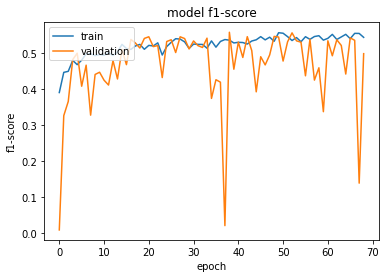

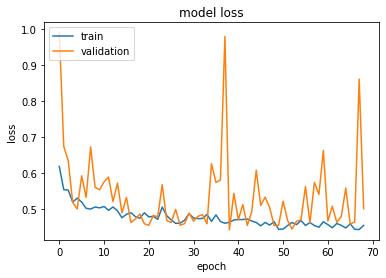

6/6 [==============================] - 1s 32ms/step - loss: 0.4239 - precision: 0.4869 - recall: 0.7008 - f1-score: 0.5743 - iou_score: 0.4049


In [15]:
# 遍历不同的滤波器数量、学习率和批量大小以训练多个模型
# 滤波器数量循环
for fiilter in filters: 
    # 学习率循环
    for learning_rate in lr:
        #  批量大小循环
        for batch in batch_size:
            # 使用当前的超参数设置加载模型
            model = attn_unet(filtersFirstLayer= fiilter, lr = learning_rate, input_size = (size,size,img_bands))
             # 设置早停法回调，防止过拟合，如果验证集上的损失在30轮内没有改善则停止训练
            early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',  # 监控验证集上的损失
                              patience = 30, 
                              restore_best_weights = True) # 恢复到最佳模型的权重
            # 设置模型检查点回调，在每个时期结束时保存模型，只有当验证集上的损失减少时才会保存模型
            model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'../data/SAR_dataset/weights/unet_{sampling}_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}.hdf5', monitor='val_loss', mode='min',verbose=1, save_best_only=True,save_weights_only = True)
            # 打印当前的超参数设置
            print(fiilter, learning_rate,batch)
            #  开始训练模型，使用20%的数据作为验证集
            history = model.fit(X_train,Y_train,batch_size = batch,epochs=epochs,validation_split=0.2,callbacks = [model_checkpoint, early_stop])
            #  绘制和保存F1分数变化图表，帮助可视化训练和验证性能
            plt.plot(history.history['f1-score'])
            plt.plot(history.history['val_f1-score'])
            plt.title('model f1-score')
            plt.ylabel('f1-score')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.savefig(f"../data/SAR_dataset/plots/unet_{sampling}_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}_f1_score.png")
            plt.show()
            
            
            #  绘制和保存损失函数变化图表
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'], loc='upper left')
            plt.savefig(f"../data/SAR_dataset/plots/unet_{sampling}_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}_val_loss.png")
            plt.show()
            
            
             # 评估模型在测试数据上的性能
            attn_unet = attn_unet(filtersFirstLayer= fiilter, lr = learning_rate,input_size=(size,size,img_bands))
            attn_unet.load_weights(f"../data/SAR_dataset/weights/unet_{sampling}_size_{size}_filters_{fiilter}_batch_size_{batch}_lr_{learning_rate}.hdf5")
            res_1= attn_unet.evaluate(X_test,Y_test)
            # 将模型的性能指标添加到结果字典
            dic["model"].append("Attention_Unet")
            dic["batch_size"].append(batch)
            dic["learning_rate"].append(learning_rate)
            dic["filters"].append(fiilter)
            dic["precision_area"].append(res_1[1])
            dic["recall_area"].append(res_1[2])
            dic["f1_score_area"].append(res_1[3])
            dic["iou_score_area"].append(res_1[4])
            


            #将结果字典转化为DataFrame并导出到CSV文件，方便之后分析和比较
            results = pd.DataFrame(dic)
            results.to_csv(f'../data/SAR_dataset/results/results_Att_Unet.csv', index = False)
